In [226]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor as gbr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [227]:
# 下载 SimHei.ttf 字体文件并放在工作目录
# 如果已经下载了字体文件，请确保路径正确
font_path = '/Users/yue.a.tao/Desktop/Downloads/SimHei.ttf'

# 将字体文件添加到 Matplotlib
fm.fontManager.addfont(font_path)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [150]:
# 读取CSV文件
data = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/combined_data3.csv")

# 查看数据结构
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            5145 non-null   int64  
 1   Date                  5145 non-null   object 
 2   大辊速度                  5145 non-null   float64
 3   1号辊轮速度                5145 non-null   float64
 4   1号辊间隙                 5145 non-null   float64
 5   2号辊轮速度                5145 non-null   float64
 6   2号辊间隙                 5145 non-null   float64
 7   3号辊轮速度                5145 non-null   float64
 8   3号辊间隙                 5145 non-null   float64
 9   Forming Roller 辊轮速度   5145 non-null   float64
 10  Forming Roller 定型辊间隙  5145 non-null   float64
 11  1号冷辊入口温度              5145 non-null   float64
 12  2号冷辊入口温度              5145 non-null   float64
 13  Item                  5145 non-null   object 
 14  entry_type            5145 non-null   int64  
 15  Weight               

In [151]:
# Drop any unnamed columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# 删除 'entry_type' 列等列
data = data.drop(columns=['entry_type','Weight_smoothed', 'batch'])

# 确保Date列是datetime类型
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d %H:%M:%S")

# 将因子变量编码
le_item = LabelEncoder()
data['Item'] = le_item.fit_transform(data['Item'])

le_sugar = LabelEncoder()
data['Sugar'] = le_sugar.fit_transform(data['Sugar'])

# 查看数据结构
print(data.info())

# 查看处理后的数据
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  5145 non-null   datetime64[ns]
 1   大辊速度                  5145 non-null   float64       
 2   1号辊轮速度                5145 non-null   float64       
 3   1号辊间隙                 5145 non-null   float64       
 4   2号辊轮速度                5145 non-null   float64       
 5   2号辊间隙                 5145 non-null   float64       
 6   3号辊轮速度                5145 non-null   float64       
 7   3号辊间隙                 5145 non-null   float64       
 8   Forming Roller 辊轮速度   5145 non-null   float64       
 9   Forming Roller 定型辊间隙  5145 non-null   float64       
 10  1号冷辊入口温度              5145 non-null   float64       
 11  2号冷辊入口温度              5145 non-null   float64       
 12  Item                  5145 non-null   int64         
 13  Weight            

In [152]:
# 对所有数值型参数列生成_diff列
# 这个新列的值是当前列的值减去前一个行的值（使用 shift(1) 函数实现）
for col in data.columns:
    if col not in ['Date', 'Item', 'Weight','Sugar']:
        data[f'{col}_diff'] = data[col] - data[col].shift(1)
        data.loc[0, f'{col}_diff'] = 0

In [103]:
# # 特征工程：生成前10秒和前10个重量的均值
# data['Weight_lag10sec'] = data['Weight'].shift(10)
# data['Weight_lag10'] = data['Weight'].rolling(window=10).mean()

# # 用 Weight 列的前十个数字弥补 Weight_lag10sec 的前十个空缺值
# data.loc[:9, 'Weight_lag10sec'] = data.loc[:9, 'Weight']

# # 用 Weight 列的前九个数字弥补 Weight_lag10 的前九个空缺值
# data.loc[:8, 'Weight_lag10'] = data.loc[:8, 'Weight']

# # 生成Weight_Diff列
# data['Weight_Diff'] = data['Weight'] - data['Weight'].shift(1)
# data.loc[0, 'Weight_Diff'] = 0

# # 生成Time_Diff列
# data['Time_Diff'] = data['Date'].diff().dt.total_seconds()
# data.loc[0, 'Time_Diff'] = 0

In [153]:
# 特征工程：对于生成前10秒和前10个重量的均值，修改为不包括当前数据
data['Weight_lag10sec'] = data['Weight'].shift(1).rolling(window=10, min_periods=1).mean()
data['Weight_lag10'] = data['Weight'].shift(1).rolling(window=10, min_periods=1).mean()

# 用 Weight 列的前十个数字弥补 Weight_lag10sec 的前十个空缺值
data.loc[:9, 'Weight_lag10sec'] = data.loc[:9, 'Weight']

# 用 Weight 列的前九个数字弥补 Weight_lag10 的前九个空缺值
data.loc[:8, 'Weight_lag10'] = data.loc[:8, 'Weight']

# 生成 Weight_Diff 列：上一个 Weight 和上上一个 Weight 的差值
data['Weight_Diff'] = data['Weight'].shift(1) - data['Weight'].shift(2)
data['Weight_Diff'].fillna(0, inplace=True)

# 生成 Time_Diff 列：上一个 Time 和上上一个 Time 的差值（秒）
data['Time_Diff'] = data['Date'].diff().shift(-1).dt.total_seconds()
data['Time_Diff'].fillna(0, inplace=True)

In [163]:
data.head(10)

,Date,大辊速度,1号辊轮速度,1号辊间隙,2号辊轮速度,2号辊间隙,3号辊轮速度,3号辊间隙,Forming Roller 辊轮速度,Forming Roller 定型辊间隙,...,3号辊轮速度_diff,3号辊间隙_diff,Forming Roller 辊轮速度_diff,Forming Roller 定型辊间隙_diff,1号冷辊入口温度_diff,2号冷辊入口温度_diff,Weight_lag10sec,Weight_lag10,Weight_Diff,Time_Diff
0,2024-05-27 17:15:17,23.1,84.6,0.1018,122.5,0.0657,141.7,0.064,165.8,0.0619,...,0.0,0.000,0.0,0.0000,0.0,0.0,35.20,35.200000,0.00,9.0
1,2024-05-27 17:15:26,23.1,84.6,0.1018,122.5,0.0657,141.7,0.064,165.8,0.0619,...,0.0,0.000,0.0,0.0000,0.0,0.0,35.15,35.150000,0.00,1056.0
2,2024-05-27 17:33:02,22.4,83.8,0.1018,121.3,0.0657,140.3,0.064,165.8,0.0606,...,-1.4,0.000,0.0,-0.0013,-3.2,-3.2,34.97,34.970000,-0.05,8.0
3,2024-05-27 17:33:10,22.4,83.8,0.1018,121.3,0.0657,140.3,0.064,165.8,0.0606,...,0.0,0.000,0.0,0.0000,0.0,0.0,35.11,35.110000,-0.18,325.0
4,2024-05-27 17:38:35,22.9,83.8,0.1018,121.3,0.0657,140.3,0.064,165.8,0.0606,...,0.0,0.000,0.0,0.0000,-1.0,-1.0,35.04,35.040000,0.14,10.0
5,2024-05-27 17:38:45,22.9,83.8,0.1018,121.3,0.0657,140.3,0.064,165.7,0.0606,...,0.0,0.000,-0.1,0.0000,-0.1,-0.1,35.44,35.440000,-0.07,3.0
6,2024-05-27 17:38:48,22.9,83.8,0.1018,121.3,0.0657,140.3,0.064,165.7,0.0606,...,0.0,0.000,0.0,0.0000,0.0,0.0,35.30,35.300000,0.40,310.0
7,2024-05-27 17:43:58,23.1,83.8,0.1009,121.3,0.0652,140.3,0.063,165.8,0.0606,...,0.0,-0.001,0.1,0.0000,-0.5,-0.5,34.96,34.960000,-0.14,4.0
8,2024-05-27 17:44:02,23.1,83.8,0.1009,121.2,0.0652,140.3,0.063,165.7,0.0606,...,0.0,0.000,-0.1,0.0000,0.0,0.0,34.94,34.940000,-0.34,13.0
9,2024-05-27 17:44:15,23.1,83.8,0.1009,121.3,0.0652,140.3,0.063,165.8,0.0606,...,0.0,0.000,0.1,0.0000,0.0,0.0,35.30,35.123333,-0.02,4.0


In [155]:
# 删除原始的 Date 列
X = data.drop(columns=['Date', 'Weight'])  # 删除 Date 和 Weight 列，Weight 是目标变量
y = data['Weight']

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   大辊速度                       5145 non-null   float64
 1   1号辊轮速度                     5145 non-null   float64
 2   1号辊间隙                      5145 non-null   float64
 3   2号辊轮速度                     5145 non-null   float64
 4   2号辊间隙                      5145 non-null   float64
 5   3号辊轮速度                     5145 non-null   float64
 6   3号辊间隙                      5145 non-null   float64
 7   Forming Roller 辊轮速度        5145 non-null   float64
 8   Forming Roller 定型辊间隙       5145 non-null   float64
 9   1号冷辊入口温度                   5145 non-null   float64
 10  2号冷辊入口温度                   5145 non-null   float64
 11  Item                       5145 non-null   int64  
 12  Sugar                      5145 non-null   int64  
 13  大辊速度_diff                  5145 non-null   float

In [156]:
print(X.head())

   大辊速度  1号辊轮速度   1号辊间隙  2号辊轮速度   2号辊间隙  3号辊轮速度  3号辊间隙  Forming Roller 辊轮速度  \
0  23.1    84.6  0.1018   122.5  0.0657   141.7  0.064                165.8   
1  23.1    84.6  0.1018   122.5  0.0657   141.7  0.064                165.8   
2  22.4    83.8  0.1018   121.3  0.0657   140.3  0.064                165.8   
3  22.4    83.8  0.1018   121.3  0.0657   140.3  0.064                165.8   
4  22.9    83.8  0.1018   121.3  0.0657   140.3  0.064                165.8   

   Forming Roller 定型辊间隙  1号冷辊入口温度  ...  3号辊轮速度_diff  3号辊间隙_diff  \
0                0.0619      -9.3  ...          0.0         0.0   
1                0.0619      -9.3  ...          0.0         0.0   
2                0.0606     -12.5  ...         -1.4         0.0   
3                0.0606     -12.5  ...          0.0         0.0   
4                0.0606     -13.5  ...          0.0         0.0   

   Forming Roller 辊轮速度_diff  Forming Roller 定型辊间隙_diff  1号冷辊入口温度_diff  \
0                       0.0                     0

In [157]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并训练Gradient Boosting模型
model = gbr()
model.fit(X_train, y_train)

# 评估模型
score = model.score(X_test, y_test)

# 打印模型得分
print(f"Model Score: {score}")
# Model Score: 0.5608714708543369 with param diff 
# Model Score: 0.5551101840504549

Model Score: 0.10676580605210928


In [158]:
# 输出特征重要性
feature_importance = model.feature_importances_
features = X.columns

# 创建一个数据框来存储特征及其重要性
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [159]:
print(feature_importance_df)

                      Feature  Importance
25               Weight_lag10    0.165274
24            Weight_lag10sec    0.145876
26                Weight_Diff    0.128546
27                  Time_Diff    0.076480
22              1号冷辊入口温度_diff    0.045564
17                 2号辊间隙_diff    0.039491
8        Forming Roller 定型辊间隙    0.038114
4                       2号辊间隙    0.034250
1                      1号辊轮速度    0.028839
0                        大辊速度    0.028311
7         Forming Roller 辊轮速度    0.025568
19                 3号辊间隙_diff    0.024926
2                       1号辊间隙    0.024504
9                    1号冷辊入口温度    0.024006
10                   2号冷辊入口温度    0.023139
23              2号冷辊入口温度_diff    0.022695
6                       3号辊间隙    0.019331
15                 1号辊间隙_diff    0.018871
21  Forming Roller 定型辊间隙_diff    0.017435
11                       Item    0.017037
13                  大辊速度_diff    0.013803
3                      2号辊轮速度    0.009914
5                      3号辊轮速度    0

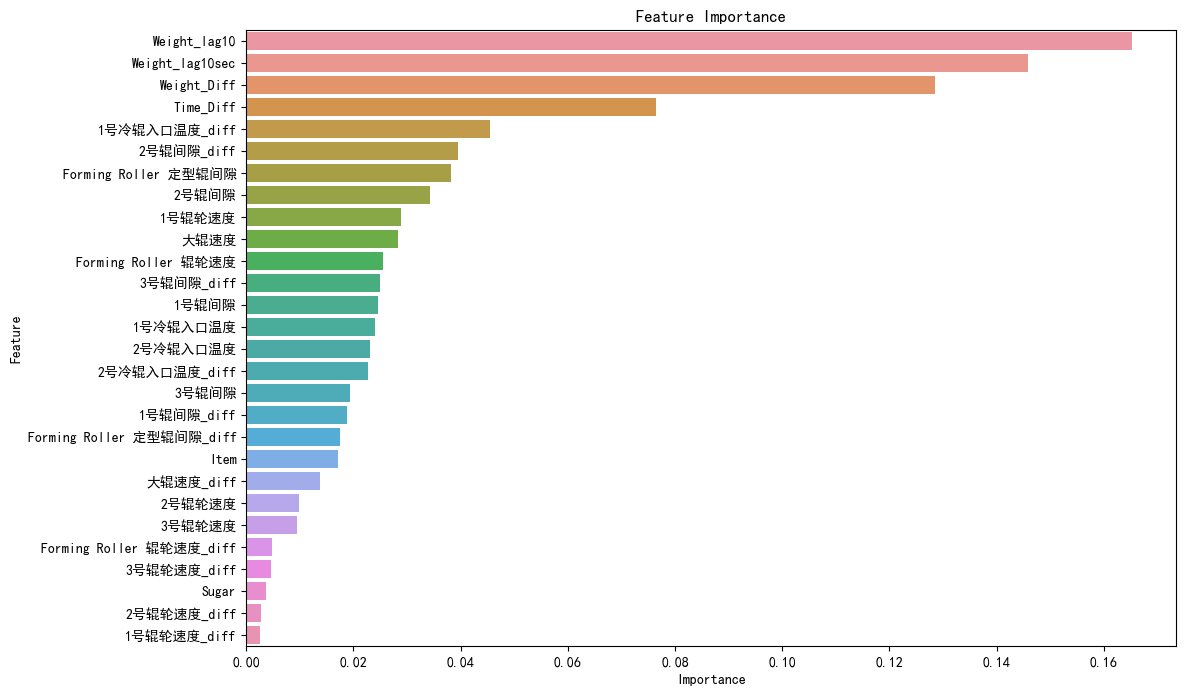

In [160]:
# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [161]:
# 初始化并训练LightGBM模型
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 评估模型
score = model.score(X_test, y_test)

# 打印模型得分
print(f"Model Score: {score}")

# [LightGBM] [Info] Total Bins 1886
# [LightGBM] [Info] Number of data points in the train set: 4116, number of used features: 17
# [LightGBM] [Info] Start training from score 35.276618
# Model Score: 0.5638095960922962 
# Model Score: 0.5549468761284111 with para diff
# Model Score: 0.5649021745925882 without para diff and new data 

Model Score: 0.1020194764833271


In [55]:
# 输出特征重要性
feature_importance = model.feature_importances_
features = X.columns

# 创建一个数据框来存储特征及其重要性
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                 Feature  Importance
14          Weight_lag10         544
15           Weight_Diff         450
13       Weight_lag10sec         361
16             Time_Diff         232
9               1号冷辊入口温度         175
8   Forming Roller 定型辊间隙         175
4                  2号辊间隙         168
10              2号冷辊入口温度         163
0                   大辊速度         138
1                 1号辊轮速度         111
2                  1号辊间隙          96
7    Forming Roller 辊轮速度          95
5                 3号辊轮速度          94
3                 2号辊轮速度          78
11                  Item          63
6                  3号辊间隙          57
12                 Sugar           0


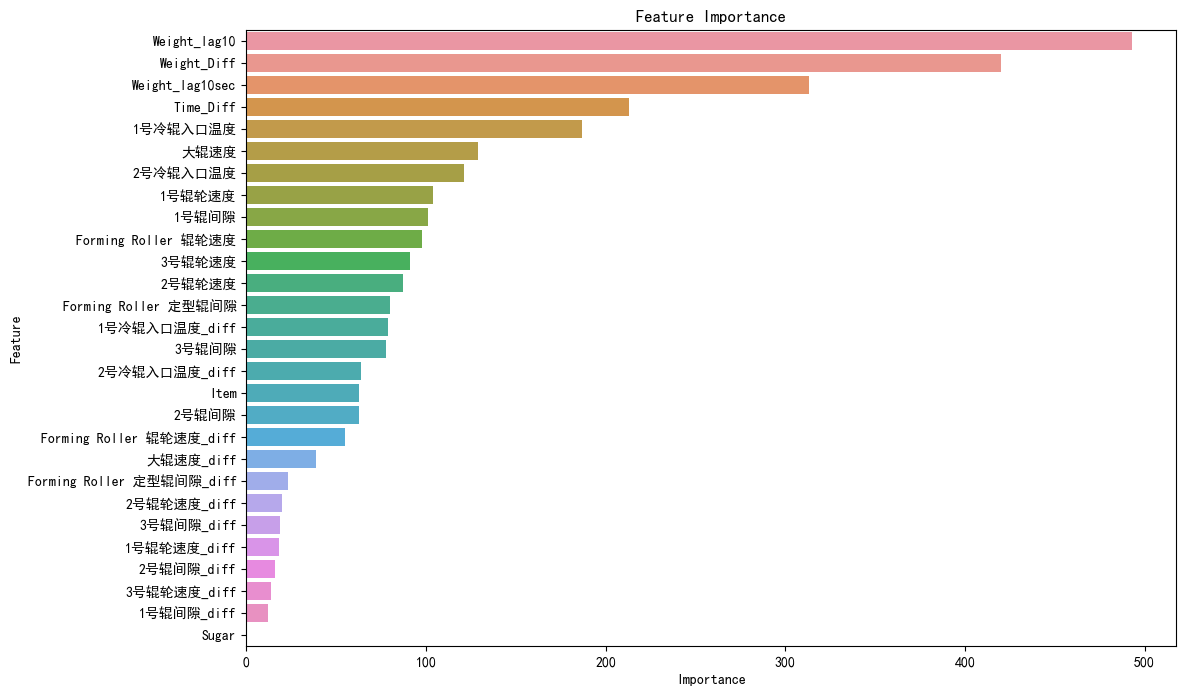

In [35]:
# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [56]:
# 初始化并训练随机森林模型
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 评估模型
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

# 打印模型得分和均方误差
print(f"Model Score: {score}")
print(f"Mean Squared Error: {mse}")

# Model Score: 0.526634996666173
# Mean Squared Error: 0.023965026997084322

# Model Score: 0.5339949717411492 with para diff
# Mean Squared Error: 0.023592413896987265 with para diff

# Model Score: 0.5274842514333493
# Mean Squared Error: 0.023922031817298222

Model Score: 0.5274842514333493
Mean Squared Error: 0.023922031817298222


In [57]:
# 输出特征重要性
feature_importance = model.feature_importances_
features = X.columns

# 创建一个数据框来存储特征及其重要性
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                 Feature  Importance
15           Weight_Diff    0.388335
14          Weight_lag10    0.274233
13       Weight_lag10sec    0.052683
16             Time_Diff    0.044432
8   Forming Roller 定型辊间隙    0.029665
4                  2号辊间隙    0.026382
0                   大辊速度    0.023286
10              2号冷辊入口温度    0.022177
7    Forming Roller 辊轮速度    0.020561
2                  1号辊间隙    0.020325
9               1号冷辊入口温度    0.020304
1                 1号辊轮速度    0.018073
5                 3号辊轮速度    0.015363
6                  3号辊间隙    0.015274
3                 2号辊轮速度    0.015184
11                  Item    0.013351
12                 Sugar    0.000373


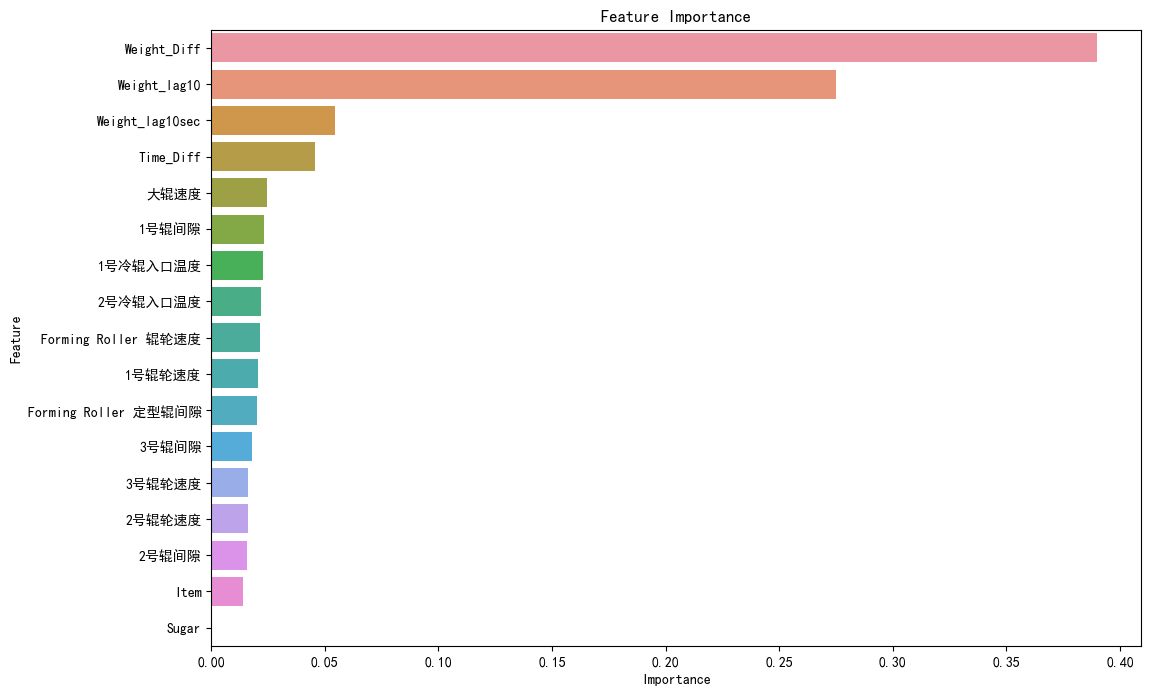

In [38]:
# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [121]:
# 读取CSV文件
data = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/combined_data3.csv")

# 查看数据结构
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            5145 non-null   int64  
 1   Date                  5145 non-null   object 
 2   大辊速度                  5145 non-null   float64
 3   1号辊轮速度                5145 non-null   float64
 4   1号辊间隙                 5145 non-null   float64
 5   2号辊轮速度                5145 non-null   float64
 6   2号辊间隙                 5145 non-null   float64
 7   3号辊轮速度                5145 non-null   float64
 8   3号辊间隙                 5145 non-null   float64
 9   Forming Roller 辊轮速度   5145 non-null   float64
 10  Forming Roller 定型辊间隙  5145 non-null   float64
 11  1号冷辊入口温度              5145 non-null   float64
 12  2号冷辊入口温度              5145 non-null   float64
 13  Item                  5145 non-null   object 
 14  entry_type            5145 non-null   int64  
 15  Weight               

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[437]	valid's rmse: 0.149235
Mean Squared Error: 0.022270952146452708
R^2 Score: 0.5600969137929324
                      Feature  Importance
42                Weight_Diff        2048
41               Weight_lag10        1966
40            Weight_lag10sec         805
27              Weight_std_60         632
24             Weight_mean_60         603
43                  Time_Diff         552
8        Forming Roller 定型辊间隙         473
9                    1号冷辊入口温度         449
31             Weight_std_300         419
26              Weight_min_60         351
4                       2号辊间隙         348
35             Weight_std_600         339
28            Weight_mean_300         321
36           Weight_mean_1800         302
25              Weight_max_60         281
10                   2号冷辊入口温度         279
39            Weight_std_1800         272
32            Weight_mean_600         249
22    

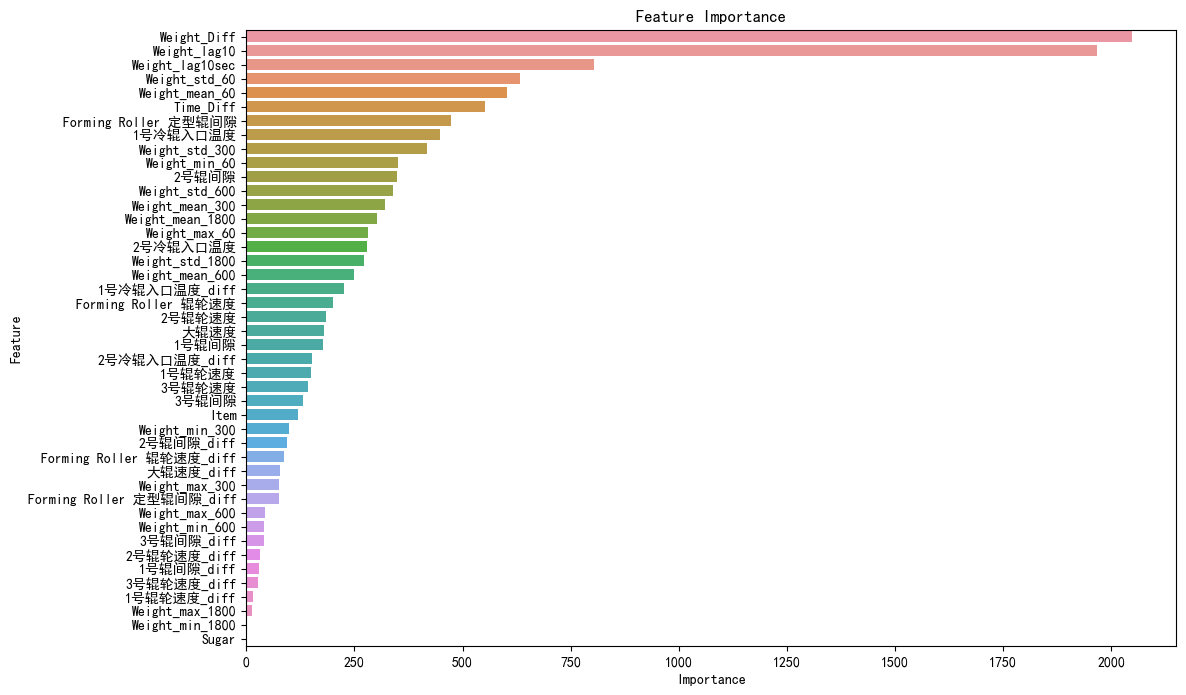

In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Download SimHei.ttf font file and place it in the working directory
font_path = '/Users/yue.a.tao/Desktop/Downloads/SimHei.ttf'

# Add the font file to Matplotlib
fm.fontManager.addfont(font_path)
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei font
plt.rcParams['axes.unicode_minus'] = False  # Correctly display negative signs

# Read CSV file
data = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/combined_data3.csv")

# Remove the first column and unnecessary columns
data = data.iloc[:, 1:].drop(columns=['entry_type', 'Weight_smoothed', 'batch'])

# Ensure Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d %H:%M:%S")

# Encode categorical variables
le_item = LabelEncoder()
data['Item'] = le_item.fit_transform(data['Item'])

le_sugar = LabelEncoder()
data['Sugar'] = le_sugar.fit_transform(data['Sugar'])

# Generate _diff columns for all numeric parameters
for col in data.columns:
    if col not in ['Date', 'Item', 'Sugar', 'Weight']:
        data[f'{col}_diff'] = data[col] - data[col].shift(1)
        data.loc[0, f'{col}_diff'] = 0

# Sliding window features
window_sizes = [60, 300, 600, 1800]  # 1 minute, 5 minutes, 10 minutes, 30 minutes

for window in window_sizes:
    data[f'Weight_mean_{window}'] = data['Weight'].rolling(window=window).mean()
    data[f'Weight_max_{window}'] = data['Weight'].rolling(window=window).max()
    data[f'Weight_min_{window}'] = data['Weight'].rolling(window=window).min()
    data[f'Weight_std_{window}'] = data['Weight'].rolling(window=window).std()

# Fill NaN values
data.fillna(method='ffill', inplace=True)

# Feature engineering: Generate lag features
data['Weight_lag10sec'] = data['Weight'].shift(10)
data['Weight_lag10'] = data['Weight'].rolling(window=10).mean()
data.loc[:9, 'Weight_lag10sec'] = data.loc[:9, 'Weight']
data.loc[:8, 'Weight_lag10'] = data.loc[:8, 'Weight']

# Generate Weight_Diff and Time_Diff columns
data['Weight_Diff'] = data['Weight'] - data['Weight'].shift(1)
data.loc[0, 'Weight_Diff'] = 0
data['Time_Diff'] = data['Date'].diff().dt.total_seconds()
data.loc[0, 'Time_Diff'] = 0

# Delete Date column and define target variable
X = data.drop(columns=['Date', 'Weight'])
y = data['Weight']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the LightGBM model with early stopping
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model with the best number of boosting rounds
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    valid_names=['valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


# Output feature importance
feature_importance = gbm.feature_importance()
features = X.columns

# Create a dataframe to store features and their importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [129]:
!pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/c4/ef/c7a0349eec94535d37498a06c033dab2793fdfd7751d461ea3a47f4d23af/prophet-1.1.5-py3-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/5d/12/6522f3de83ca690aa52f4b8c88a1e203abb1e2d75c31669dc004949143cd/cmdstanpy-1.2.4-py3-none-any.whl.metadata
  Obtaining dependency information for holidays>=0.25 from https://files.pythonhosted.org/packages/c1/e4/63aa666d39dddfeaaaff1f58416d2a9c756c9b88037eae1b0d954c06d5bd/holidays-0.54-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/75/06/4df55e1b7b112d183f65db9503bff189e97179b256e1ea450a3c365241e0/importlib_resources-6.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd98d

23:11:29 - cmdstanpy - INFO - Chain [1] start processing
23:11:30 - cmdstanpy - INFO - Chain [1] done processing


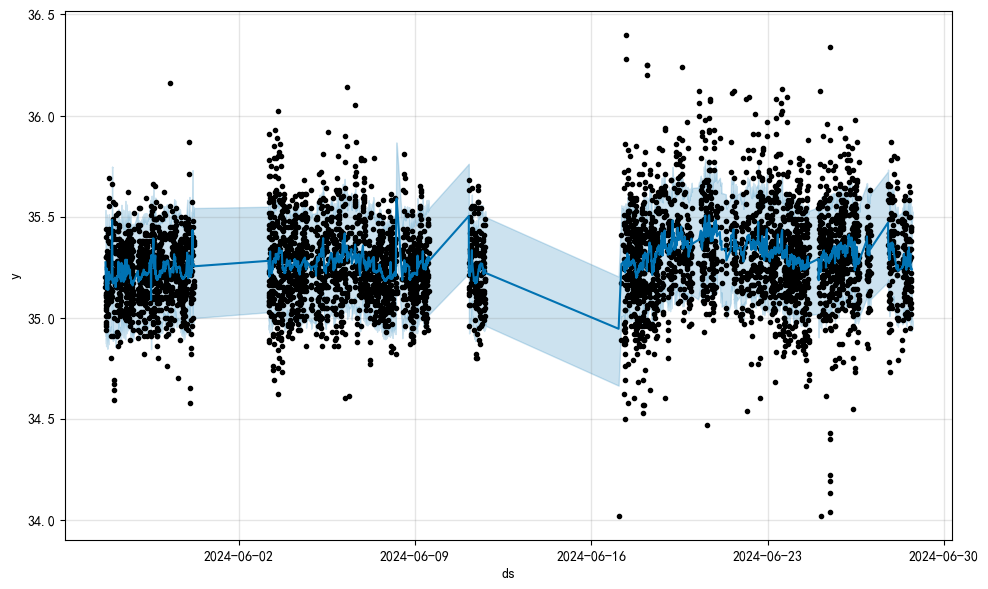

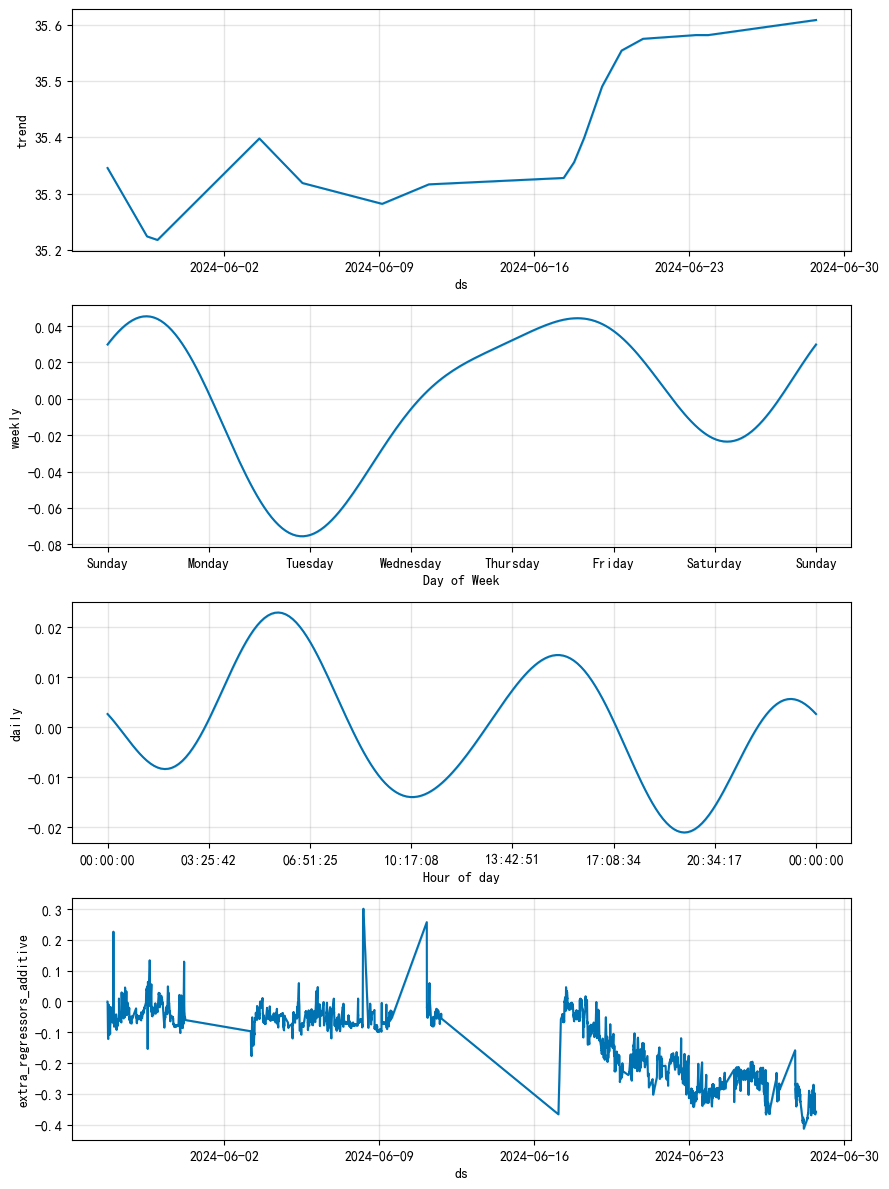

Mean Squared Error: 0.04447572270502492


In [139]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load your data
data = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/combined_data3.csv")

# Ensure Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d %H:%M:%S")

# Drop any unnamed columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Drop unnecessary columns
data = data.drop(columns=['entry_type', 'Weight_smoothed', 'batch'])

# Encode categorical variables
le_item = LabelEncoder()
data['Item'] = le_item.fit_transform(data['Item'])

le_sugar = LabelEncoder()
data['Sugar'] = le_sugar.fit_transform(data['Sugar'])

# Handle missing values by filling them with the median value of each column
data.fillna(data.median(), inplace=True)

# Prepare data for Prophet
data_prophet = data[['Date', 'Weight']].rename(columns={'Date': 'ds', 'Weight': 'y'})

# Ensure all numeric regressors are included in data_prophet
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Weight']]

for col in numeric_cols:
    data_prophet[col] = data[col]

# Initialize the Prophet model
model = Prophet()

# Add regressors
for col in numeric_cols:
    model.add_regressor(col)

# Fit the model
model.fit(data_prophet)

# Create a dataframe for future dates (next 30 minutes, assuming 1-second intervals)
future = model.make_future_dataframe(periods=1800, freq='S')

# Add the same regressors to the future dataframe
for col in numeric_cols:
    # Ensure the length matches and fill missing values with the last available value
    future[col] = data_prophet[col].reindex(future.index, method='ffill').values

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

# Calculate and print the Mean Squared Error (MSE) on the training set
train_predictions = forecast[forecast['ds'] <= data['Date'].max()]['yhat']
train_true = data['Weight']
mse = mean_squared_error(train_true, train_predictions)
print(f'Mean Squared Error: {mse}')

In [141]:
# Calculate and print the R² score
r2 = r2_score(train_true, train_predictions)
print(f'R² Score: {r2}')

R² Score: 0.08294596682122535


Gradient Boosting Regressor - R²: 0.5506849640240901, MSE: 0.0269254962011984
Random Forest Regressor - R²: 0.5188712072484298, MSE: 0.02883195629850709
XGBoost - R²: 0.4826142635217081, MSE: 0.03100467726801689
LightGBM - R²: 0.5296409070793675, MSE: 0.028186575021078603


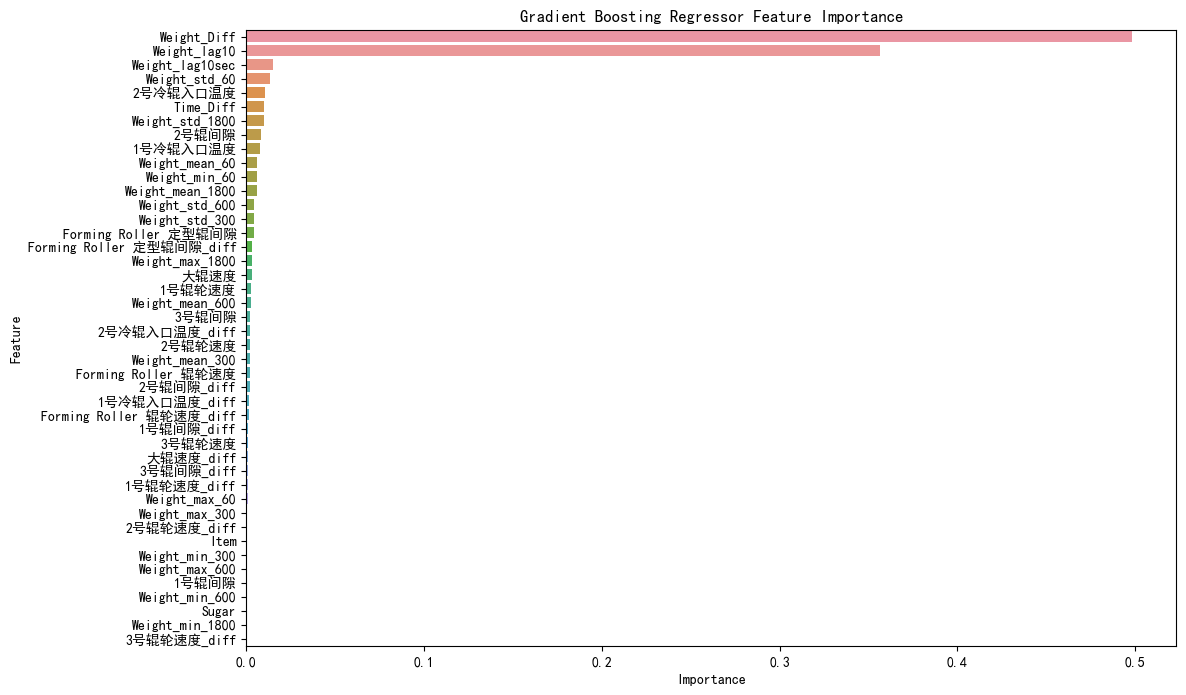

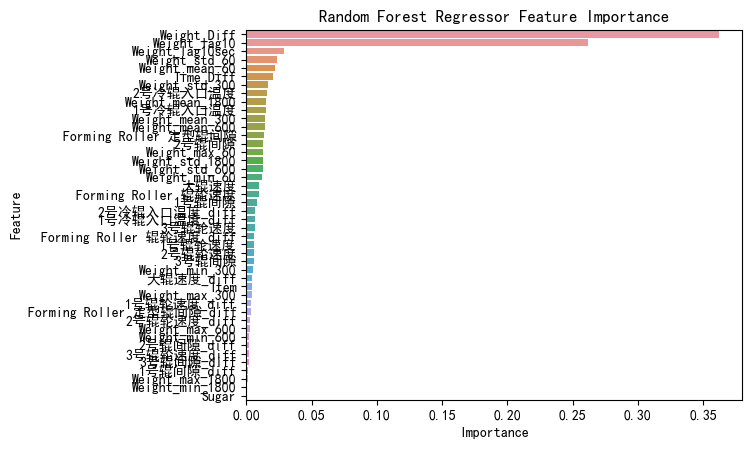

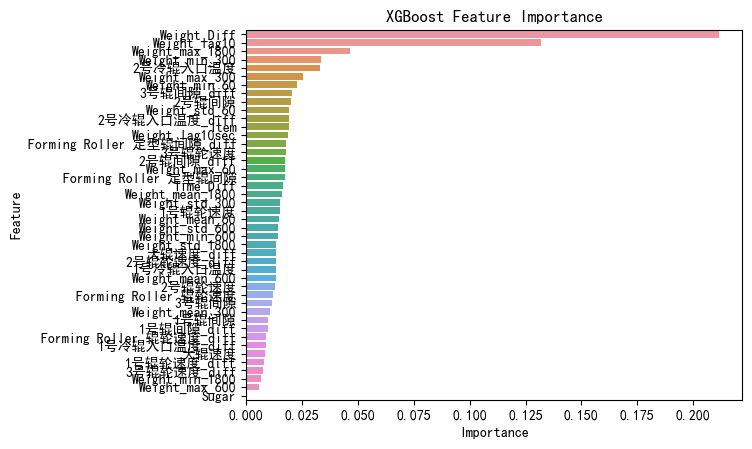

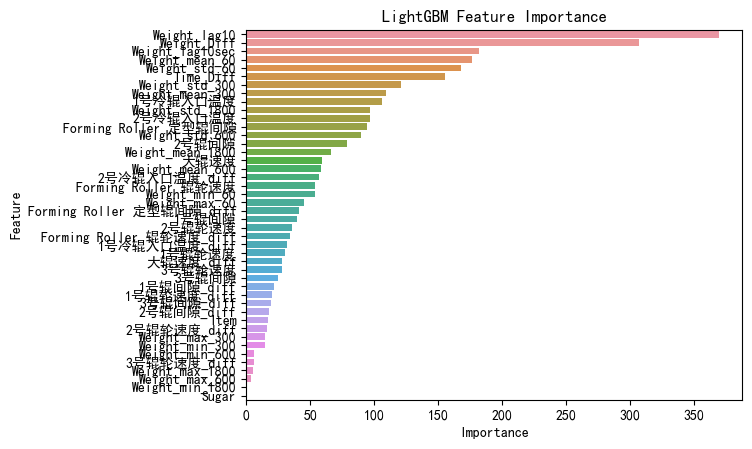

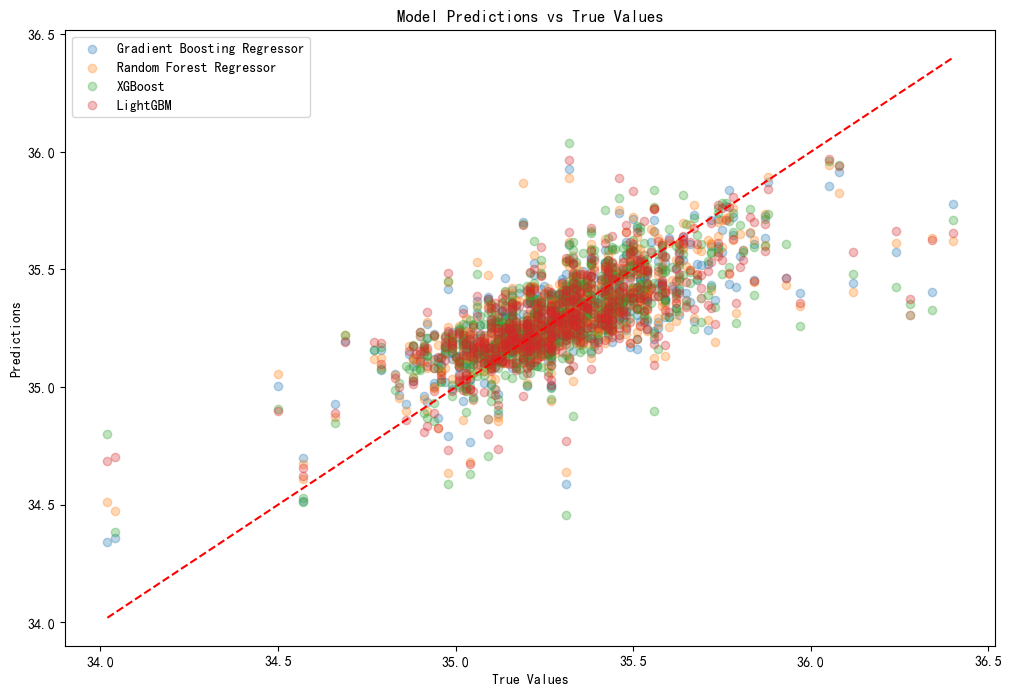

In [146]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV file
data = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/combined_data3.csv")

# Remove the first column and unnecessary columns
data = data.iloc[:, 1:].drop(columns=['entry_type', 'Weight_smoothed', 'batch'])

# Ensure Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d %H:%M:%S")

# Encode categorical variables
le_item = LabelEncoder()
data['Item'] = le_item.fit_transform(data['Item'])

le_sugar = LabelEncoder()
data['Sugar'] = le_sugar.fit_transform(data['Sugar'])

# Generate _diff columns for all numeric parameters
for col in data.columns:
    if col not in ['Date', 'Item', 'Sugar', 'Weight']:
        data[f'{col}_diff'] = data[col] - data[col].shift(1)
        data.loc[0, f'{col}_diff'] = 0

# Sliding window features
window_sizes = [60, 300, 600, 1800]  # 1 minute, 5 minutes, 10 minutes, 30 minutes

for window in window_sizes:
    data[f'Weight_mean_{window}'] = data['Weight'].rolling(window=window).mean()
    data[f'Weight_max_{window}'] = data['Weight'].rolling(window=window).max()
    data[f'Weight_min_{window}'] = data['Weight'].rolling(window=window).min()
    data[f'Weight_std_{window}'] = data['Weight'].rolling(window=window).std()

# Fill NaN values
data.fillna(method='ffill', inplace=True)

# Feature engineering: Generate lag features
data['Weight_lag10sec'] = data['Weight'].shift(10)
data['Weight_lag10'] = data['Weight'].rolling(window=10).mean()
data.loc[:9, 'Weight_lag10sec'] = data.loc[:9, 'Weight']
data.loc[:8, 'Weight_lag10'] = data.loc[:8, 'Weight']

# Generate Weight_Diff and Time_Diff columns
data['Weight_Diff'] = data['Weight'] - data['Weight'].shift(1)
data.loc[0, 'Weight_Diff'] = 0
data['Time_Diff'] = data['Date'].diff().dt.total_seconds()
data.loc[0, 'Time_Diff'] = 0

# 删除包含NA的行
data.dropna(inplace=True)

# Delete Date column and define target variable
X = data.drop(columns=['Date', 'Weight'])
y = data['Weight']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 模型列表
models = {
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor()
}

# 存储结果
results = {}

# 训练和评估每个模型
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {
        'model': model,
        'r2_score': r2,
        'mse': mse,
        'feature_importance': model.feature_importances_ if name != 'LightGBM' else model.booster_.feature_importance(importance_type='split')
    }

# 打印模型性能
for name, result in results.items():
    print(f"{name} - R²: {result['r2_score']}, MSE: {result['mse']}")

# 可视化特征重要性
plt.figure(figsize=(12, 8))
for name, result in results.items():
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result['feature_importance']})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'{name} Feature Importance')
    plt.show()

# 可视化预测和真实值
plt.figure(figsize=(12, 8))
for name, result in results.items():
    plt.scatter(y_test, result['model'].predict(X_test), alpha=0.3, label=name)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Model Predictions vs True Values')
plt.legend()
plt.show()

Gradient Boosting Regressor - R²: 0.5583521773761029, MSE: 0.02235928283215536
Random Forest Regressor - R²: 0.5312103901151766, MSE: 0.023733388775510247
XGBoost - R²: 0.5106583901097053, MSE: 0.02477387388004142
LightGBM - R²: 0.5627244478333582, MSE: 0.022137928108403666


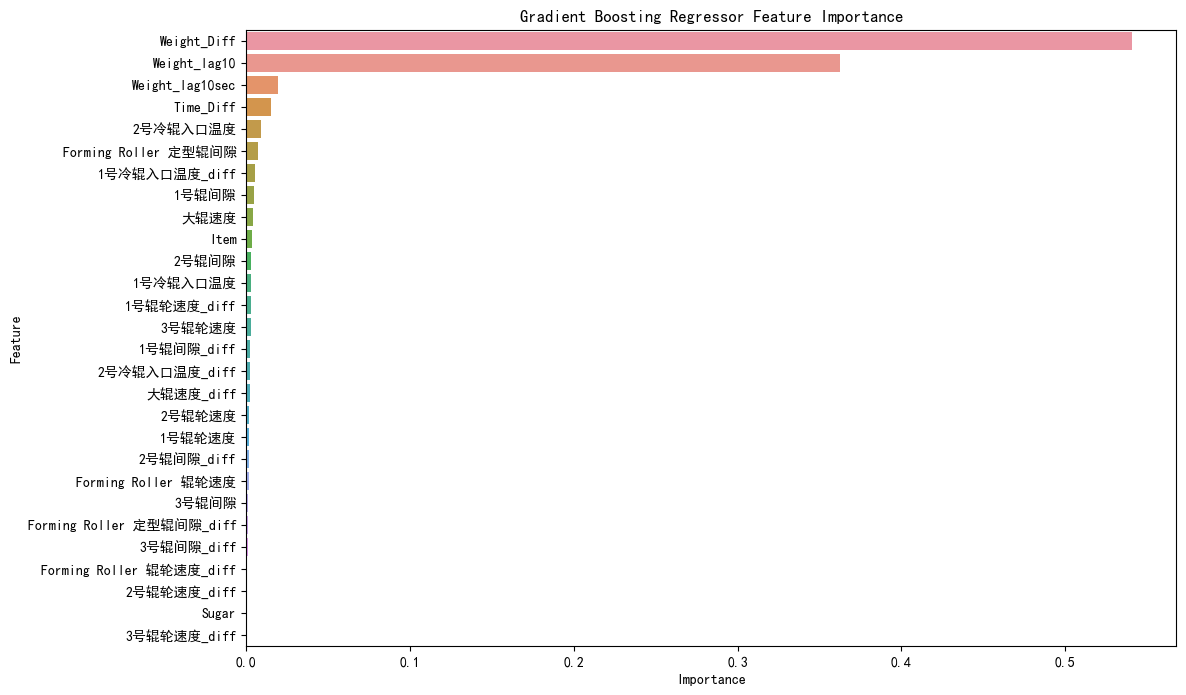

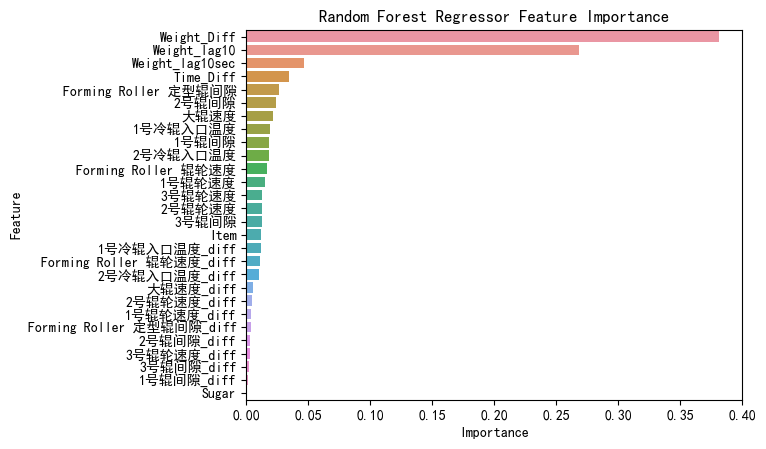

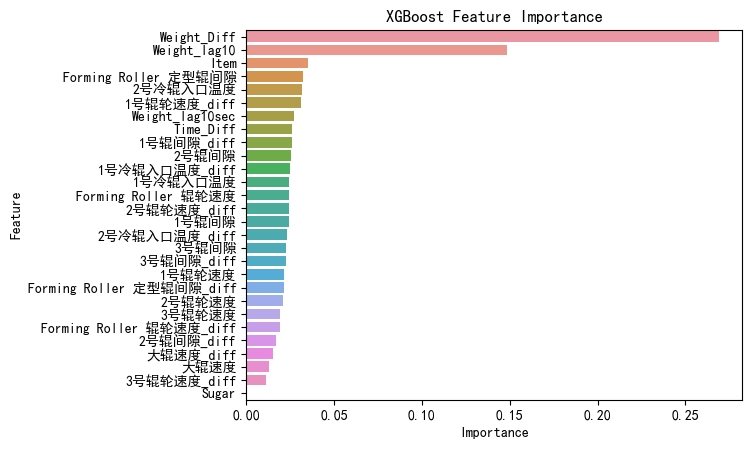

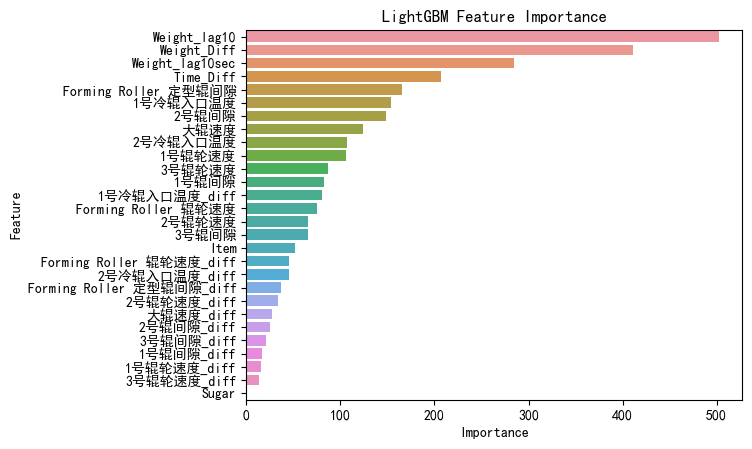

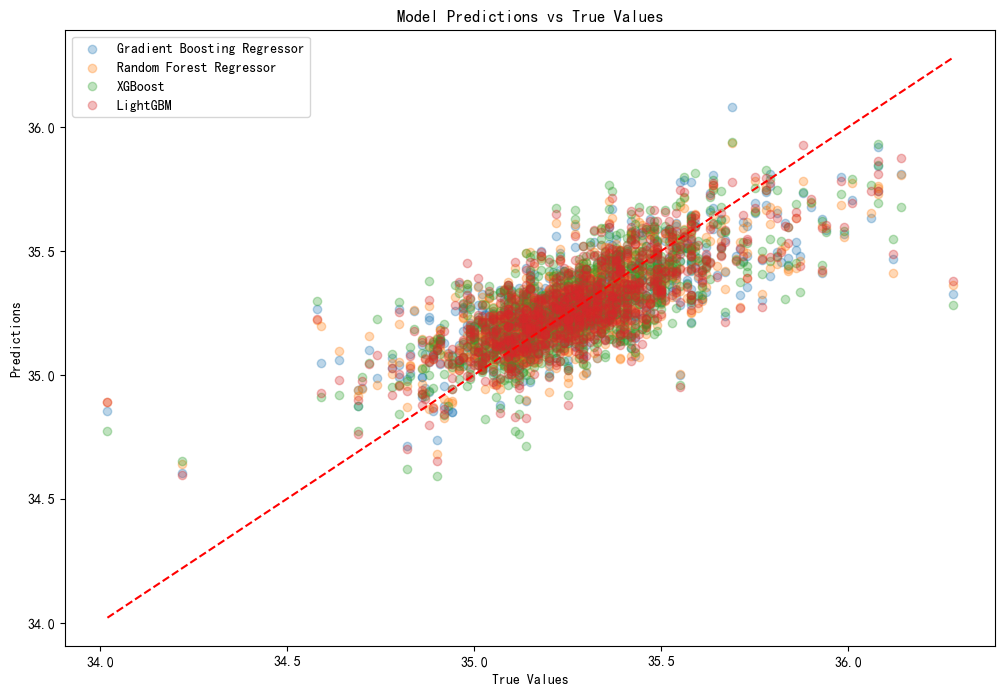

In [147]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV file
data = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/combined_data3.csv")

# Remove the first column and unnecessary columns
data = data.iloc[:, 1:].drop(columns=['entry_type', 'Weight_smoothed', 'batch'])

# Ensure Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d %H:%M:%S")

# Encode categorical variables
le_item = LabelEncoder()
data['Item'] = le_item.fit_transform(data['Item'])

le_sugar = LabelEncoder()
data['Sugar'] = le_sugar.fit_transform(data['Sugar'])

# Generate _diff columns for all numeric parameters
for col in data.columns:
    if col not in ['Date', 'Item', 'Sugar', 'Weight']:
        data[f'{col}_diff'] = data[col] - data[col].shift(1)
        data.loc[0, f'{col}_diff'] = 0

# Sliding window features
# window_sizes = [60, 300, 600, 1800]  # 1 minute, 5 minutes, 10 minutes, 30 minutes

# for window in window_sizes:
#    data[f'Weight_mean_{window}'] = data['Weight'].rolling(window=window).mean()
#    data[f'Weight_max_{window}'] = data['Weight'].rolling(window=window).max()
#    data[f'Weight_min_{window}'] = data['Weight'].rolling(window=window).min()
#    data[f'Weight_std_{window}'] = data['Weight'].rolling(window=window).std()

# Fill NaN values
# data.fillna(method='ffill', inplace=True)

# Feature engineering: Generate lag features
data['Weight_lag10sec'] = data['Weight'].shift(10)
data['Weight_lag10'] = data['Weight'].rolling(window=10).mean()
data.loc[:9, 'Weight_lag10sec'] = data.loc[:9, 'Weight']
data.loc[:8, 'Weight_lag10'] = data.loc[:8, 'Weight']

# Generate Weight_Diff and Time_Diff columns
data['Weight_Diff'] = data['Weight'] - data['Weight'].shift(1)
data.loc[0, 'Weight_Diff'] = 0
data['Time_Diff'] = data['Date'].diff().dt.total_seconds()
data.loc[0, 'Time_Diff'] = 0

# 删除包含NA的行
data.dropna(inplace=True)

# Delete Date column and define target variable
X = data.drop(columns=['Date', 'Weight'])
y = data['Weight']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 模型列表
models = {
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor()
}

# 存储结果
results = {}

# 训练和评估每个模型
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {
        'model': model,
        'r2_score': r2,
        'mse': mse,
        'feature_importance': model.feature_importances_ if name != 'LightGBM' else model.booster_.feature_importance(importance_type='split')
    }

# 打印模型性能
for name, result in results.items():
    print(f"{name} - R²: {result['r2_score']}, MSE: {result['mse']}")

# 可视化特征重要性
plt.figure(figsize=(12, 8))
for name, result in results.items():
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result['feature_importance']})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'{name} Feature Importance')
    plt.show()

# 可视化预测和真实值
plt.figure(figsize=(12, 8))
for name, result in results.items():
    plt.scatter(y_test, result['model'].predict(X_test), alpha=0.3, label=name)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Model Predictions vs True Values')
plt.legend()
plt.show()

In [167]:
# Read CSV file
para = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/para.csv")

para.info()
para.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  999999 non-null  object 
 1   大辊速度                  999999 non-null  float64
 2   1号辊轮速度                999999 non-null  float64
 3   1号辊间隙                 999999 non-null  float64
 4   2号辊轮速度                999999 non-null  float64
 5   2号辊间隙                 999999 non-null  float64
 6   3号辊轮速度                999999 non-null  float64
 7   3号辊间隙                 999999 non-null  float64
 8   Forming Roller 辊轮速度   999999 non-null  float64
 9   Forming Roller 定型辊间隙  999999 non-null  float64
 10  1号冷辊入口温度              999999 non-null  float64
 11  2号冷辊入口温度              999999 non-null  float64
dtypes: float64(11), object(1)
memory usage: 91.6+ MB


,Date,大辊速度,1号辊轮速度,1号辊间隙,2号辊轮速度,2号辊间隙,3号辊轮速度,3号辊间隙,Forming Roller 辊轮速度,Forming Roller 定型辊间隙,1号冷辊入口温度,2号冷辊入口温度
0,2024-05-27 15:53:16,16.7,60.4,0.0991,87.5,0.0679,101.2,0.063,118.6,0.0641,10.1,4.0
1,2024-05-27 15:53:17,17.8,64.5,0.0991,93.4,0.0679,108.0,0.063,126.2,0.0641,10.1,4.0
2,2024-05-27 15:53:18,19.5,70.5,0.0991,102.0,0.0679,118.0,0.063,138.2,0.0641,10.1,4.0
3,2024-05-27 15:53:19,21.2,76.7,0.0991,111.0,0.0679,128.4,0.063,150.2,0.0641,10.0,4.0
4,2024-05-27 15:53:20,22.8,82.7,0.0991,119.7,0.0679,138.4,0.063,162.0,0.0641,10.0,4.0


In [166]:
weight = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/weight.csv")

weight.info()
weight.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5145 non-null   object 
 1   Item    5145 non-null   object 
 2   Weight  5145 non-null   float64
 3   Sugar   5145 non-null   object 
 4   batch   5145 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 201.1+ KB


,Date,Item,Weight,Sugar,batch
0,2024-05-27 17:12:17,DMPY（绿箭金装薄荷）,35.20,Sugar,1
1,2024-05-27 17:12:26,DMPY（绿箭金装薄荷）,35.15,Sugar,1
2,2024-05-27 17:30:02,DMPY（绿箭金装薄荷）,34.97,Sugar,1
3,2024-05-27 17:30:10,DMPY（绿箭金装薄荷）,35.11,Sugar,1
4,2024-05-27 17:35:35,DMPY（绿箭金装薄荷）,35.04,Sugar,1


In [168]:
import pandas as pd

# 转换 Date 列为日期时间格式
para['Date'] = pd.to_datetime(para['Date'])
weight['Date'] = pd.to_datetime(weight['Date'])

# 初始化结果数据框
result_list = []

# 函数：处理每个 weight 的 Date 时间戳
def process_weight(current_time, para):
    # 找到前十分钟内的所有数据
    filtered_data = para[(para['Date'] >= (current_time - pd.Timedelta(minutes=10))) & 
                         (para['Date'] <= current_time)]
    
    # 展开为一行
    expanded_data = filtered_data.drop(columns=['Date']).reset_index(drop=True).T
    expanded_data.columns = [f'{col}_{i}' for i, col in enumerate(expanded_data.columns)]
    
    # 添加当前 weight 的 Date 列
    expanded_data['Weight_Date'] = current_time
    
    return expanded_data

# 对于 weight 数据的每一个 Date 时间戳进行处理
for current_time in weight['Date']:
    expanded_data = process_weight(current_time, para)
    result_list.append(expanded_data)

# 合并结果
result = pd.concat(result_list, axis=0).reset_index(drop=True)


            0_0       1_1       2_2       3_3       4_4       5_5       6_6  \
0        0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
1       84.6000   84.6000   84.6000   84.6000   84.6000   84.6000   84.6000   
2        0.1018    0.1018    0.1018    0.1018    0.1018    0.1018    0.1018   
3      122.5000  122.5000  122.5000  122.5000  122.5000  122.5000  122.5000   
4        0.0679    0.0679    0.0679    0.0679    0.0679    0.0679    0.0679   
...         ...       ...       ...       ...       ...       ...       ...   
56590       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
56591       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
56592       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
56593       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
56594       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            7_7       8_8       9_9  ...  591_591  

In [172]:
# 查看结果
result.head()

,0_0,1_1,2_2,3_3,4_4,5_5,6_6,7_7,8_8,9_9,...,591_591,592_592,593_593,594_594,595_595,596_596,597_597,598_598,599_599,600_600
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84.6000,84.6000,84.6000,84.6000,84.6000,84.6000,84.6000,84.6000,84.6000,84.6000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.1018,0.1018,0.1018,0.1018,0.1018,0.1018,0.1018,0.1018,0.1018,0.1018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,122.5000,122.5000,122.5000,122.5000,122.5000,122.5000,122.5000,122.5000,122.5000,122.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0679,0.0679,0.0679,0.0679,0.0679,0.0679,0.0679,0.0679,0.0679,0.0679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

# 转换 Date 列为日期时间格式
para['Date'] = pd.to_datetime(para['Date'])
weight['Date'] = pd.to_datetime(weight['Date'])

# 初始化结果数据框
result_list = []

# 对于每个 weight 的 Date 时间戳进行处理
for current_time in weight['Date']:
    # 找到当前时间戳前300个数据
    filtered_data = para[para['Date'] <= current_time].tail(300).drop(columns=['Date'])
    
    # 展开为一行
    expanded_data = filtered_data.values.flatten()
    
    # 确保每行长度相同，不足的部分用NaN填充
    if len(expanded_data) < 300 * len(filtered_data.columns):
        expanded_data = np.pad(expanded_data, (0, 300 * len(filtered_data.columns) - len(expanded_data)), constant_values=np.nan)
    
    result_list.append(expanded_data)

# 转换结果为数据框
result_df = pd.DataFrame(result_list)

            PCA1        PCA2         Weight_Date  Weight
0     459.664734  131.695505 2024-05-27 17:12:17   35.20
1     459.569660  131.116839 2024-05-27 17:12:26   35.15
2     415.023983   92.150796 2024-05-27 17:30:02   34.97
3     414.893879   91.224689 2024-05-27 17:30:10   35.11
4     421.440150   52.724639 2024-05-27 17:35:35   35.04
...          ...         ...                 ...     ...
5140 -503.557287   33.367018 2024-06-28 16:35:32   35.15
5141 -503.557287   33.367018 2024-06-28 16:37:49   35.02
5142 -503.557287   33.367018 2024-06-28 16:37:51   35.05
5143 -503.557287   33.367018 2024-06-28 16:52:01   35.44
5144 -503.557287   33.367018 2024-06-28 16:52:04   35.30

[5145 rows x 4 columns]


In [174]:
# 查看结果
print(result_df)

      0     1       2      3       4      5      6      7       8     9     \
0     23.4  84.6  0.1018  122.5  0.0679  141.7  0.066  165.8  0.0641  -8.4   
1     23.4  84.6  0.1018  122.5  0.0679  141.7  0.066  165.8  0.0641  -8.2   
2     22.9  83.8  0.1018  121.3  0.0657  140.3  0.064  165.8  0.0606 -10.5   
3     22.9  83.8  0.1018  121.3  0.0657  140.3  0.064  165.8  0.0606 -10.5   
4     22.4  83.8  0.1018  121.3  0.0657  140.3  0.064  165.8  0.0606 -12.7   
...    ...   ...     ...    ...     ...    ...    ...    ...     ...   ...   
5140  18.9  61.4  0.1198   95.0  0.0801  118.6  0.068  132.2  0.0636 -18.0   
5141  18.9  61.4  0.1198   95.0  0.0801  118.6  0.068  132.2  0.0636 -18.0   
5142  18.9  61.4  0.1198   95.0  0.0801  118.6  0.068  132.2  0.0636 -18.0   
5143  18.9  61.4  0.1198   95.0  0.0801  118.6  0.068  132.2  0.0636 -18.0   
5144  18.9  61.4  0.1198   95.0  0.0801  118.6  0.068  132.2  0.0636 -18.0   

      ...  3290    3291   3292    3293   3294   3295   3296    

In [175]:
# 删除包含NA的行
result_df.dropna(inplace=True)

In [176]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Columns: 3300 entries, 0 to 3299
dtypes: float64(3300)
memory usage: 129.5 MB


In [177]:
# 转换结果为数据框
result_df = pd.DataFrame(result_df)
result_df['Weight_Date'] = weight['Date'].values
result_df['Weight'] = weight['Weight'].values

In [179]:
result_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3292,3293,3294,3295,3296,3297,3298,3299,Weight_Date,Weight
0,23.4,84.6,0.1018,122.5,0.0679,141.7,0.066,165.8,0.0641,-8.4,...,122.5,0.0657,141.7,0.064,165.8,0.0619,-9.3,-9.7,2024-05-27 17:12:17,35.20
1,23.4,84.6,0.1018,122.5,0.0679,141.7,0.066,165.8,0.0641,-8.2,...,122.5,0.0657,141.7,0.064,165.8,0.0619,-9.3,-9.7,2024-05-27 17:12:26,35.15
2,22.9,83.8,0.1018,121.3,0.0657,140.3,0.064,165.8,0.0606,-10.5,...,121.3,0.0657,140.3,0.064,165.8,0.0606,-12.5,-12.9,2024-05-27 17:30:02,34.97
3,22.9,83.8,0.1018,121.3,0.0657,140.3,0.064,165.8,0.0606,-10.5,...,121.3,0.0657,140.3,0.064,165.8,0.0606,-12.5,-12.9,2024-05-27 17:30:10,35.11
4,22.4,83.8,0.1018,121.3,0.0657,140.3,0.064,165.8,0.0606,-12.7,...,121.3,0.0657,140.3,0.064,165.8,0.0606,-13.5,-13.9,2024-05-27 17:35:35,35.04


In [180]:
# 删除原始的 Date 列
X = result_df.drop(columns=['Weight_Date', 'Weight'])  # 删除 Date 和 Weight 列，Weight 是目标变量
y = result_df['Weight']

print(X.info())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并训练Gradient Boosting模型
model = gbr()
model.fit(X_train, y_train)

# 评估模型
score = model.score(X_test, y_test)

# 打印模型得分
print(f"Model Score: {score}")
# Model Score: 0.5608714708543369 with param diff 
# Model Score: 0.5551101840504549

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Columns: 3300 entries, 0 to 3299
dtypes: float64(3300)
memory usage: 129.5 MB
None
Model Score: 0.12374212151164554


In [215]:
# Read CSV file
data = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/combined_all.csv")

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349091 entries, 0 to 1349090
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Unnamed: 0            1349091 non-null  int64  
 1   Date                  1349091 non-null  object 
 2   Item                  1346127 non-null  object 
 3   Weight                1346127 non-null  float64
 4   Sugar                 1346127 non-null  object 
 5   batch                 1346127 non-null  float64
 6   大辊速度                  1349091 non-null  float64
 7   1号辊轮速度                1349091 non-null  float64
 8   1号辊间隙                 1349091 non-null  float64
 9   2号辊轮速度                1349091 non-null  float64
 10  2号辊间隙                 1349091 non-null  float64
 11  3号辊轮速度                1349091 non-null  float64
 12  3号辊间隙                 1349091 non-null  float64
 13  Forming Roller 辊轮速度   1349091 non-null  float64
 14  Forming Roller 定型辊间隙  1349091 non-

,Unnamed: 0,Date,Item,Weight,Sugar,batch,大辊速度,1号辊轮速度,1号辊间隙,2号辊轮速度,2号辊间隙,3号辊轮速度,3号辊间隙,Forming Roller 辊轮速度,Forming Roller 定型辊间隙,1号冷辊入口温度,2号冷辊入口温度
0,1,2024-05-27 15:56:16,NaN,NaN,NaN,NaN,16.7,60.4,0.0991,87.5,0.0679,101.2,0.063,118.6,0.0641,10.1,4.0
1,2,2024-05-27 15:56:17,NaN,NaN,NaN,NaN,17.8,64.5,0.0991,93.4,0.0679,108.0,0.063,126.2,0.0641,10.1,4.0
2,3,2024-05-27 15:56:18,NaN,NaN,NaN,NaN,19.5,70.5,0.0991,102.0,0.0679,118.0,0.063,138.2,0.0641,10.1,4.0
3,4,2024-05-27 15:56:19,NaN,NaN,NaN,NaN,21.2,76.7,0.0991,111.0,0.0679,128.4,0.063,150.2,0.0641,10.0,4.0
4,5,2024-05-27 15:56:20,NaN,NaN,NaN,NaN,22.8,82.7,0.0991,119.7,0.0679,138.4,0.063,162.0,0.0641,10.0,4.0


In [216]:
# Drop any unnamed columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# 确保Date列是datetime类型
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d %H:%M:%S")

In [208]:
# 查看数据结构
data.info()

# 查看处理后的数据
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349091 entries, 0 to 1349090
Data columns (total 16 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Date                  1349091 non-null  datetime64[ns]
 1   Item                  1346127 non-null  object        
 2   Weight                1346127 non-null  float64       
 3   Sugar                 1346127 non-null  object        
 4   batch                 1346127 non-null  float64       
 5   大辊速度                  1349091 non-null  float64       
 6   1号辊轮速度                1349091 non-null  float64       
 7   1号辊间隙                 1349091 non-null  float64       
 8   2号辊轮速度                1349091 non-null  float64       
 9   2号辊间隙                 1349091 non-null  float64       
 10  3号辊轮速度                1349091 non-null  float64       
 11  3号辊间隙                 1349091 non-null  float64       
 12  Forming Roller 辊轮速度   1349091 non-null  fl

,Date,Item,Weight,Sugar,batch,大辊速度,1号辊轮速度,1号辊间隙,2号辊轮速度,2号辊间隙,3号辊轮速度,3号辊间隙,Forming Roller 辊轮速度,Forming Roller 定型辊间隙,1号冷辊入口温度,2号冷辊入口温度
0,2024-05-27 15:56:16,NaN,NaN,NaN,NaN,16.7,60.4,0.0991,87.5,0.0679,101.2,0.063,118.6,0.0641,10.1,4.0
1,2024-05-27 15:56:17,NaN,NaN,NaN,NaN,17.8,64.5,0.0991,93.4,0.0679,108.0,0.063,126.2,0.0641,10.1,4.0
2,2024-05-27 15:56:18,NaN,NaN,NaN,NaN,19.5,70.5,0.0991,102.0,0.0679,118.0,0.063,138.2,0.0641,10.1,4.0
3,2024-05-27 15:56:19,NaN,NaN,NaN,NaN,21.2,76.7,0.0991,111.0,0.0679,128.4,0.063,150.2,0.0641,10.0,4.0
4,2024-05-27 15:56:20,NaN,NaN,NaN,NaN,22.8,82.7,0.0991,119.7,0.0679,138.4,0.063,162.0,0.0641,10.0,4.0


In [192]:
# Read CSV file
weight = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/weight.csv")

weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5145 non-null   object 
 1   Item    5145 non-null   object 
 2   Weight  5145 non-null   float64
 3   Sugar   5145 non-null   object 
 4   batch   5145 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 201.1+ KB


In [193]:
# 确保Date列是datetime类型
weight['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d %H:%M:%S")

weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5145 non-null   datetime64[ns]
 1   Item    5145 non-null   object        
 2   Weight  5145 non-null   float64       
 3   Sugar   5145 non-null   object        
 4   batch   5145 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 201.1+ KB


In [194]:
import pandas as pd
import numpy as np

# 定义计算历史统计特征的函数
def calculate_stats(df, current_time):
    stats = {}
    time_windows = [30, 60, 300, 600]  # 30秒, 1分钟, 5分钟, 10分钟
    columns = df.columns.difference(['Date', 'Item', 'Sugar', 'batch', 'Weight'])
    
    for window in time_windows:
        window_data = df[(df['Date'] >= current_time - pd.Timedelta(seconds=window)) & (df['Date'] < current_time)]
        for col in columns:
            stats[f'{col}_mean_{window}s'] = window_data[col].mean()
            stats[f'{col}_max_{window}s'] = window_data[col].max()
            stats[f'{col}_min_{window}s'] = window_data[col].min()
            stats[f'{col}_std_{window}s'] = window_data[col].std()
        
        weight_data = df[(df['Date'] >= current_time - pd.Timedelta(seconds=window)) & (df['Date'] < current_time)]
        stats[f'Weight_mean_{window}s'] = weight_data['Weight'].mean()
        stats[f'Weight_max_{window}s'] = weight_data['Weight'].max()
        stats[f'Weight_min_{window}s'] = weight_data['Weight'].min()
        stats[f'Weight_std_{window}s'] = weight_data['Weight'].std()
    
    return stats

# 初始化结果数据框
result_list = []

# 对每个 weight 的 Date 时间戳进行处理
for _, row in weight.iterrows():
    current_time = row['Date']
    stats = calculate_stats(data, current_time)
    result_row = {**row.to_dict(), **stats}
    result_list.append(result_row)

# 转换结果为数据框
result = pd.DataFrame(result_list)

# 查看结果
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Columns: 197 entries, Date to Weight_std_600s
dtypes: datetime64[ns](1), float64(193), int64(1), object(2)
memory usage: 7.7+ MB


In [195]:
result.head()

,Date,Item,Weight,Sugar,batch,1号冷辊入口温度_mean_30s,1号冷辊入口温度_max_30s,1号冷辊入口温度_min_30s,1号冷辊入口温度_std_30s,1号辊轮速度_mean_30s,...,Forming Roller 辊轮速度_min_600s,Forming Roller 辊轮速度_std_600s,大辊速度_mean_600s,大辊速度_max_600s,大辊速度_min_600s,大辊速度_std_600s,Weight_mean_600s,Weight_max_600s,Weight_min_600s,Weight_std_600s
0,2024-05-27 15:56:16,DMPY（绿箭金装薄荷）,35.20,Sugar,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-05-27 15:56:17,DMPY（绿箭金装薄荷）,35.15,Sugar,1,10.100,10.1,10.1,NaN,60.400000,...,118.6,NaN,16.70,16.7,16.7,NaN,NaN,NaN,NaN,NaN
2,2024-05-27 15:56:18,DMPY（绿箭金装薄荷）,34.97,Sugar,1,10.100,10.1,10.1,0.00,62.450000,...,118.6,5.374012,17.25,17.8,16.7,0.777817,NaN,NaN,NaN,NaN
3,2024-05-27 15:56:19,DMPY（绿箭金装薄荷）,35.11,Sugar,1,10.100,10.1,10.1,0.00,65.133333,...,118.6,9.881970,18.00,19.5,16.7,1.410674,NaN,NaN,NaN,NaN
4,2024-05-27 15:56:20,DMPY（绿箭金装薄荷）,35.04,Sugar,1,10.075,10.1,10.0,0.05,68.025000,...,118.6,13.857850,18.80,21.2,16.7,1.971463,NaN,NaN,NaN,NaN


In [196]:
# 删除包含NA的行
result.dropna(inplace=True)

result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2177 entries, 2966 to 5144
Columns: 197 entries, Date to Weight_std_600s
dtypes: datetime64[ns](1), float64(193), int64(1), object(2)
memory usage: 3.3+ MB


In [228]:
# Read CSV file
result = pd.read_csv("/Users/yue.a.tao/Desktop/Desktop/Gum/Data/result.csv")

result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Columns: 209 entries, Unnamed: 0 to 2号冷辊入口温度
dtypes: float64(204), int64(2), object(3)
memory usage: 7.8+ MB


In [229]:
# Drop any unnamed columns
result = result.loc[:, ~result.columns.str.contains('^Unnamed')]

# 确保Date列是datetime类型
result['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d %H:%M:%S")

KeyError: 'Date'

In [230]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Columns: 208 entries, Date to 2号冷辊入口温度
dtypes: float64(204), int64(1), object(3)
memory usage: 7.7+ MB


In [231]:
data = result

# Encode categorical variables
le_item = LabelEncoder()
data['Item'] = le_item.fit_transform(data['Item'])

le_sugar = LabelEncoder()
data['Sugar'] = le_sugar.fit_transform(data['Sugar'])

# Delete Date column and define target variable
X = data.drop(columns=['Date', 'Weight'])
y = data['Weight']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 模型列表
models = {
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor()
}

# 存储结果
results = {}

# 训练和评估每个模型
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {
        'model': model,
        'r2_score': r2,
        'mse': mse,
        'feature_importance': model.feature_importances_ if name != 'LightGBM' else model.booster_.feature_importance(importance_type='split')
    }

# 打印模型性能
for name, result in results.items():
    print(f"{name} - R²: {result['r2_score']}, MSE: {result['mse']}")

# # 可视化特征重要性
# plt.figure(figsize=(12, 8))
# for name, result in results.items():
#     importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result['feature_importance']})
#     importance_df = importance_df.sort_values(by='Importance', ascending=False)
#     sns.barplot(x='Importance', y='Feature', data=importance_df)
#     plt.title(f'{name} Feature Importance')
#     plt.show()

# # 可视化预测和真实值
# plt.figure(figsize=(12, 8))
# for name, result in results.items():
#     plt.scatter(y_test, result['model'].predict(X_test), alpha=0.3, label=name)

# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.title('Model Predictions vs True Values')
# plt.legend()
# plt.show()

Gradient Boosting Regressor - R²: 0.2048670928429155, MSE: 0.03517551964452152
Random Forest Regressor - R²: 0.17136900400954602, MSE: 0.03665742621788302
XGBoost - R²: 0.10024344439468957, MSE: 0.039803917196863096
LightGBM - R²: 0.1693721598708421, MSE: 0.036745763689009905


In [222]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# 数据准备
data = result

# 编码分类变量
le_item = LabelEncoder()
data['Item'] = le_item.fit_transform(data['Item'])

le_sugar = LabelEncoder()
data['Sugar'] = le_sugar.fit_transform(data['Sugar'])

# 删除 Date 列并定义目标变量
X = data.drop(columns=['Date', 'Weight'])
y = data['Weight']

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 模型列表
models = {
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor()
}

# 存储结果
results = {}

# 训练和评估每个模型
for name, model in models.items():
    # 交叉验证
    cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # 拟合模型
    model.fit(X_train, y_train)
    
    # 预测
    y_pred = model.predict(X_test)
    
    # 评估
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'r2_score': r2,
        'mse': mse,
        'mae': mae,
        'cv_r2': np.mean(cv_r2),
        'cv_mse': -np.mean(cv_mse),
        'cv_mae': -np.mean(cv_mae),
        'feature_importance': model.feature_importances_ if name != 'LightGBM' else model.booster_.feature_importance(importance_type='split')
    }

# 打印模型性能
for name, result in results.items():
    print(f"{name} - R²: {result['r2_score']}, MSE: {result['mse']}, MAE: {result['mae']}")
    print(f"{name} - CV R²: {result['cv_r2']}, CV MSE: {result['cv_mse']}, CV MAE: {result['cv_mae']}")

Gradient Boosting Regressor - R²: 0.20634736210067128, MSE: 0.03511003469240008, MAE: 0.14264677082419475
Gradient Boosting Regressor - CV R²: 0.14334553741623304, CV MSE: 0.041986702644625486, CV MAE: 0.1529994659687007
Random Forest Regressor - R²: 0.1914205043038395, MSE: 0.03577037710174738, MAE: 0.1426663926002053
Random Forest Regressor - CV R²: 0.13866050057620735, CV MSE: 0.042291869465463955, CV MAE: 0.15183068950041417
XGBoost - R²: 0.10024344439468957, MSE: 0.039803917196863096, MAE: 0.1520501022103634
XGBoost - CV R²: 0.021664834164777113, CV MSE: 0.04799835024779233, CV MAE: 0.16241415859410124
LightGBM - R²: 0.1693721598708421, MSE: 0.036745763689009905, MAE: 0.1468781135084474
LightGBM - CV R²: 0.11108944499500481, CV MSE: 0.04361735626350891, CV MAE: 0.15497955957434079


In [218]:
import pandas as pd
import numpy as np

# 定义计算历史统计特征的函数
def calculate_stats(df, current_time):
    stats = {}
    time_windows = [30, 60, 300, 600]  # 30秒, 1分钟, 5分钟, 10分钟
    columns = df.columns.difference(['Date', 'Item', 'Sugar', 'batch', 'Weight'])
    
    for window in time_windows:
        window_data = df[(df['Date'] >= current_time - pd.Timedelta(seconds=window)) & (df['Date'] < current_time)]
        
        if window_data.empty:
            continue
        
        for col in columns:
            stats[f'{col}_mean_{window}s'] = window_data[col].mean()
            stats[f'{col}_max_{window}s'] = window_data[col].max()
            stats[f'{col}_min_{window}s'] = window_data[col].min()
            stats[f'{col}_std_{window}s'] = window_data[col].std()
        
        stats[f'Weight_mean_{window}s'] = window_data['Weight'].mean()
        stats[f'Weight_max_{window}s'] = window_data['Weight'].max()
        stats[f'Weight_min_{window}s'] = window_data['Weight'].min()
        stats[f'Weight_std_{window}s'] = window_data['Weight'].std()
    
    return stats

# 初始化结果数据框
result_list = []

# 对每个 weight 的 Date 时间戳进行处理
for _, row in weight.iterrows():
    current_time = row['Date']
    stats = calculate_stats(data, current_time)
    # 获取当前时间的数据行，保留原始列和值
    original_values = data[data['Date'] == current_time].drop(columns=['Date', 'Item', 'Sugar', 'batch', 'Weight'])
    original_values = original_values.iloc[0].to_dict() if not original_values.empty else {}
    result_row = {**row.to_dict(), **stats, **original_values}
    result_list.append(result_row)

# 转换结果为数据框
result = pd.DataFrame(result_list)

# 删除包含NA的行
result = result.dropna()

# 查看结果
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2177 entries, 2966 to 5144
Columns: 208 entries, Date to Weight_std_600s
dtypes: datetime64[ns](1), float64(204), int64(1), object(2)
memory usage: 3.5+ MB
